In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.2.1 requires torchmetrics>=0.7.0, which is not installed.
litdata 0.2.2 requires torch>=2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.18.0 requires torch==2.3.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
litdata 0.2.2 requires torch>=2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.2.1 requires torchmetrics>=0.7.0, which is not installed.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2

In [2]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libnspr4 libnss3 libpoppler97 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libnspr4 libnss3 libpoppler97 poppler-data poppler-utils
0 upgraded, 5 newly installed, 0 to remove and 3 not upgraded.
Need to get 4063 kB of archives.
After this operation, 21.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 poppler-data all 0.4.9-2 [1475 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libnspr4 amd64 2:4.35-0ubuntu0.20.04.1 [108 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libnss3 amd64 2:3.98-0ubuntu0.20.04.2 [1391 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal

In [3]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
#from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


ModuleNotFoundError: No module named 'pydantic_v1.class_validators'; 'pydantic_v1' is not a package

## Data

In [ ]:
!mkdir pdfs

mkdir: cannot create directory ‘pdfs’: File exists


In [ ]:
!gdown 1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr -O pdfs/tesla-earnings-report.pdf
!gdown 1Xc890jrQvCExAkryVWAttsv1DBLdVefN -O pdfs/nvidia-earnings-report.pdf
!gdown 1Epz-SQ3idPpoz75GlTzzomag8gplzLv8 -O pdfs/meta-earnings-report.pdf

Downloading...
From: https://drive.google.com/uc?id=1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr
To: /teamspace/studios/this_studio/dl_python/nlp/llama3_finetune/pdfs/tesla-earnings-report.pdf
100%|████████████████████████████████████████| 345k/345k [00:00<00:00, 23.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xc890jrQvCExAkryVWAttsv1DBLdVefN
To: /teamspace/studios/this_studio/dl_python/nlp/llama3_finetune/pdfs/nvidia-earnings-report.pdf
100%|████████████████████████████████████████| 414k/414k [00:00<00:00, 29.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Epz-SQ3idPpoz75GlTzzomag8gplzLv8
To: /teamspace/studios/this_studio/dl_python/nlp/llama3_finetune/pdfs/meta-earnings-report.pdf
100%|████████████████████████████████████████| 183k/183k [00:00<00:00, 18.2MB/s]


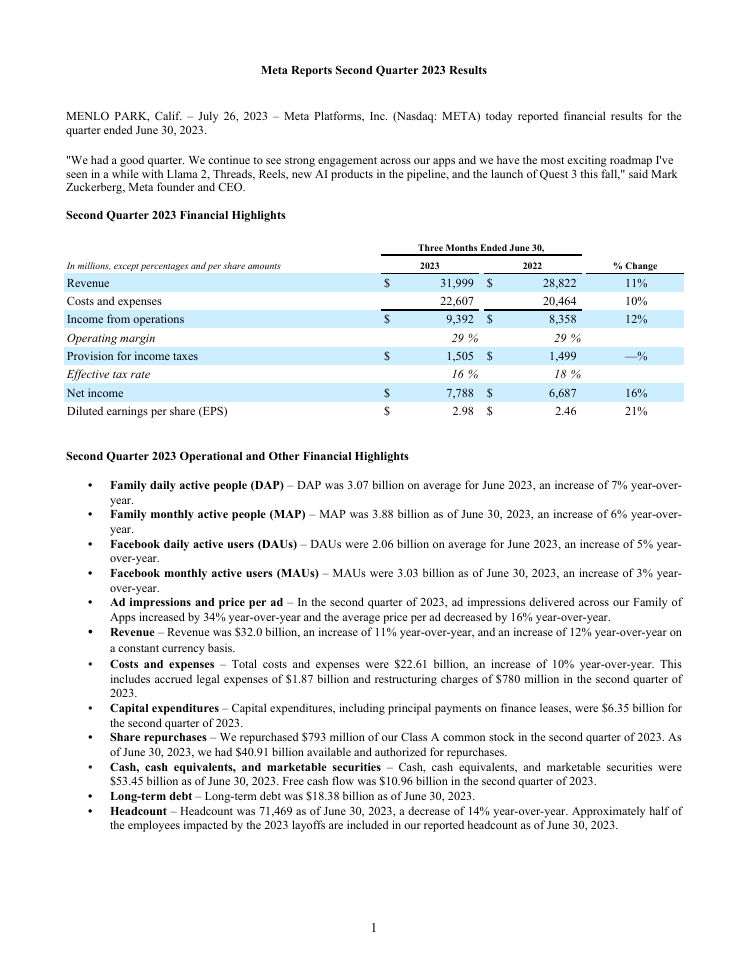

In [ ]:
meta_images = convert_from_path("pdfs/meta-earnings-report.pdf", dpi=88)
meta_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

100

In [ ]:
from langchain.vectorstores import Chroma

embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

db = Chroma.from_documents(texts, embeddings, persist_directory="db")

load INSTRUCTOR_Transformer
max_seq_length  512


## Llama 2 13B

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

Exllama kernel is not installed, reset disable_exllama to True. This may because you installed auto_gptq using a pre-build wheel on Windows, in which exllama_kernels are not compiled. To use exllama_kernels to further speedup inference, you can re-install auto_gptq from source.
CUDA kernels for auto_gptq are not installed, this will result in very slow inference speed. This may because:
1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

CUDA extension not installed.
skip module injection for FusedLlamaMLPForQuantizedModel not support integrate without triton yet.


In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.3.0+cu121)
    Python  3.10.11 (you have 3.10.14)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCau

## Chat with Multiple PDFs

## Use this part to chat with FAQ of a website

1. Crawl text from the FAQ
2. Convert to embeddings as above
3. Use RAG to answer questions based on FAQ
4. Demo the difference

In [ ]:
result = qa_chain("Provide a summary of meta earnings in 2023?")

 Based on the information provided in the press release, here is a summary of Meta's earnings in 2023:

* Revenue: $31.999 

KeyboardInterrupt: 

In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Meta Reports Second  Quarter 2023  Results
MENLO PARK, Calif. – July 26, 2023  – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the 
quarter ended June 30, 2023 .
"We had a good quarter. We continue to see strong engagement across our apps and we have the most exciting roadmap I've 
seen in a while with Llama 2, Threads, Reels, new AI products in the pipeline, and the launch of Quest 3 this fall," said Mark 
Zuckerberg, Meta founder and CEO.
Second Quarter 2023  Financial Highlights
Three Months Ended June 30,
In millions, except percentages and per share amounts 2023 2022 % Change
Revenue $ 31,999 $ 28,822 11%
Costs and expenses  22,607  20,464 10%
Income from operations $ 9,392 $ 8,358 12%
Operating margin  29 %  29 %
Provision for income taxes $ 1,505 $ 1,499 —%
Effective tax rate  16 %  18 %
Net income $ 7,788 $ 6,687 16%
Diluted earnings per share (EPS) $ 2.98 $ 2.46 21%
Second Quarter 2023  Operational and Other Financial Highlights


In [ ]:
result = qa_chain("What is the per share revenue for Tesla during 2023?")

 I can't determine the per share revenue for Tesla in 2023 based on the information provided. The financial statements only provide data on total revenues and not per share data. Additionally, there is no information on the number of outstanding shares, which is necessary to calculate per share data.


In [ ]:
result = qa_chain("What is the per share revenue for Nvidia during 2023?")

 Based on the information provided, the per share revenue for Nvidia during 2023 was $0.83. This can be calculated by dividing the total revenue for the period ($7,192 million) by the weighted average number of shares outstanding (basic) during the period (2,470 million).


In [ ]:
print(result["source_documents"][1].page_content)

PART I. FINANCIAL INFORMATION
ITEM 1.  FINANCIAL STATEMENTS (UNAUDITED)
NVIDIA CORPORATION AND SUBSIDIARIES
CONDENSED CONSOLIDATED STATEMENTS OF INCOME
(In millions, except per share data)
(Unaudited)
 Three Months Ended
 April 30, May 1,
2023 2022
Revenue $ 7,192 $ 8,288 
Cost of revenue 2,544 2,857 
Gross profit 4,648 5,431 
Operating expenses   
Research and development 1,875 1,618 
Sales, general and administrative 633 592 
Acquisition termination cost — 1,353 
Total operating expenses 2,508 3,563 
Income from operations 2,140 1,868 
Interest income 150 18 
Interest expense (66) (68)
Other, net (15) (13)
Other income (expense), net 69 (63)
Income before income tax 2,209 1,805 
Income tax expense 166 187 
Net income $ 2,043 $ 1,618 
Net income per share:
Basic $ 0.83 $ 0.65 
Diluted $ 0.82 $ 0.64 
Weighted average shares used in per share computation:
Basic 2,470 2,506 
Diluted 2,490 2,537 
See accompanying Notes to Condensed Consolidated Financial Statements.
3


In [ ]:
result = qa_chain("What is the estimated YOY revenue for Meta during 2023?")

 Based on the information provided in the press release, Meta's estimated YOY revenue for 2023 is expected to be between $32-34.5 billion, which represents an increase of 11-16% over 2022.


In [ ]:
result = qa_chain("What is the estimated YOY revenue for Tesla during 2023?")

 Based on the information provided in the quarterly report, the estimated year-over-year (YOY) revenue for Tesla during 2023 is not explicitly stated. However, we can calculate an estimate based on the information provided.

For the six months ended June 30, 2023, Tesla's revenues were $41,231 million, representing a decrease of $768 million compared to the same period in 2022. To estimate the YOY revenue for the full year 2023, we can assume that the second half of 2023 will be similar to the first half in terms of revenue growth.

Assuming no significant changes in market conditions or business operations, we can project the full-year 2023 revenue based on the first half's performance as follows:

Full-year 2023 revenue = (First half 2023 revenue x 2) + (Second half 2022 revenue x 1)

where "Second half 2022 revenue" represents the revenue generated during the last six months of 2022.

Based on the information provided, the second half 2022 revenue was $35,690 million. Therefore, the

In [ ]:
result = qa_chain("What is the estimated YOY revenue for Nvidia during 2023?")

 Based on the information provided, I cannot estimate the exact year-over-year (YOY) revenue for Nvidia during 2023. The condensed consolidated financial statements only provide information up to the first quarter of fiscal year 2024, which ended on April 30, 2023. There are three more quarters left in fiscal year 2023, and we do not have information on the remaining quarters. Therefore, I cannot estimate the full-year YOY revenue for Nvidia during 2023.


In [ ]:
result = qa_chain(
    "Which company is more profitable during 2023 Meta, Nvidia or Tesla and why?"
)

 I cannot determine which company is more profitable during 2023 between Meta, Nvidia, and Tesla based on the information provided. The passage only discusses Nvidia's financial condition and results of operations, but does not provide any information about Meta or Tesla's financial performance during 2023. Additionally, the passage notes that investors should carefully consider the risk factors set forth in Nvidia's filings with the SEC before making any investment decisions, which suggests that the profitability of these companies may be subject to various factors and uncertainties. Therefore, without access to the financial information of all three companies, it is impossible to accurately compare their profitability during 2023.


In [ ]:
result = qa_chain(
    "Choose one company to invest (Tesla, Nvidia or Meta) to maximize your profits for the long term (10+ years)?"
)

 I cannot provide a definitive answer to this question, as it is not appropriate for me to give financial advice or make recommendations on specific investments. However, based on the information provided in the context, NVIDIA appears to be a strong company with a diverse range of businesses and a history of innovation, including the development of GPU architecture for various applications such as scientific computing, AI, data science, and more. Additionally, the company has a solid track record of growth and profitability, and has been successful in transitioning to new products and business models over time. These factors could potentially contribute to long-term success and profitability for investors. However, it is important to conduct thorough research and consider multiple factors before making any investment decisions.


## References

- [Tesla Quarterly Report (Jul 21, 2023)](https://ir.tesla.com/_flysystem/s3/sec/000095017023033872/tsla-20230630-gen.pdf)
- [Meta Q2 2023 Earnings (Jul 26, 2023)](https://s21.q4cdn.com/399680738/files/doc_financials/2023/q2/Meta-06-30-2023-Exhibit-99-1-FINAL.pdf)
- [Nvidia Fiscal Q1 2024](https://s201.q4cdn.com/141608511/files/doc_financials/2024/q1/ecefb2b2-efcb-45f3-b72b-212d90fcd873.pdf)